# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Model parameters

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import numpy as np
import itertools
import spm1d
import os
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
path2data = '/home/romain/Desktop/envergo/parameter/'
mat = sio.loadmat(os.path.join(path2data, 'Parametres.mat'))

## Data description
- `mat['PARAMETRES']`: raw model parameters (_used in the following sections_)
    - size: $35 \text{ (participants)} \times 7 \text{ (parameters)} \times 6 \text{ (positions)} \times 2 \text{ (contractions)}$
- `mat['parametres']`: model parameters converted in _SI_ units
- `mat['ERR']`: optimization residuals

<img src="../../../Downloads/envergo//ParametresModele.png" width="800">
- Expected variables in spm: $J \text{ (observations)} \times Q \text{ (frames)} \times I \text{ (variables)}$
    - `y`: $n \times 7$
    - `A`: $n \times 1$

In [3]:
nparticipant, nparameter, nposition, ncontraction = mat['PARAMETRES'].shape
y, positions = [[] for i in range(2)]
contraction = 1  # 0: flexion | 1: extension

for iparticipant in range(nparticipant):
    for iposition in range(nposition):
        y.append(mat['PARAMETRES'][iparticipant, :, iposition, contraction])
        positions.append(iposition)

y, positions = [np.array(i) for i in [y, positions]]
print('----dimension----'.upper())
funct = lambda x, y: print(f'{x} shape: {y.shape} | has {np.isnan(y).sum()} nans')
funct('y', y)
funct('positions', positions)

----DIMENSION----
y shape: (210, 7) | has 175 nans
positions shape: (210,) | has 0 nans


In [4]:
# replace missing trial by mean of the position
for iposition in np.unique(positions):
    idx = positions == iposition
    mean_vector = np.nanmean(y[idx, :], axis=0)
    y[idx,  :] = np.where(np.isnan(y[idx, :]), mean_vector, y[idx, :])
funct('y', y)
funct('positions', positions)

y shape: (210, 7) | has 0 nans
positions shape: (210,) | has 0 nans


In [5]:
def display_results(spm, kind=None, title=None, indent=''):
    print(title.upper())
    var = 'X' if kind == 'manova' else 'T'
    if spm.h0reject:
        print(f'{indent}null hypothesis rejected, {var}2={spm.z:.3f}, p={spm.p:.5f}')
    else:
        print(f'{indent}null hypothesis not rejected')

In [13]:
def spm_heatmap(df, title=None, labels=None, save_fig=False, cmap='viridis'):
    fig, axs = plt.subplots(figsize=(8, 4))
    ax = sns.heatmap(df, linewidths=.5, cbar_kws={'label': 'T statistic'},
                     annot=True, xticklabels=labels, yticklabels=labels, cmap=cmap, fmt='g')
    #ax = sns.heatmap(df, linewidths=.5, cbar_kws={'label': 'T statistic'},
                     #vmin=0.0001, vmax=0.05, annot=True, xticklabels=labels, yticklabels=labels)
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()
    
    if save_fig:
        fig.savefig('./share/fig/{}.pdf'.format(title), transparent=True)

## One-way MANOVA (non-parametric)

In [7]:
alpha = 0.05
iterations = 50
np.random.seed(0)

m_spm = spm1d.stats.nonparam.manova1(y, positions)
m_spmi = m_spm.inference(alpha=alpha, iterations=iterations)

display_results(m_spmi, title='one-way manova', kind='manova')

ONE-WAY MANOVA
null hypothesis rejected, X2=99.206, p=0.02000


- There was a significant main effect for position ($p<0.001$)
- As the manova reach significance, we can conduct separate Hotelling’s T$^2$ tests on each pair of groups
    - If those tests reach significance then conduct additional post hoc t tests on each vector component, but acknowledge that this neglects vector component covariance.

## Post hoc analysis (non-parametric paired Hotellings's T2 and paired t-test)

In [11]:
n_positions = len(set(positions))
combinations = itertools.combinations(range(n_positions), 2)
names_positions = ['Ref', 'Abd90IR', 'Flex90IR', 'Flex180ER', 'Abd90ER', 'Flex90ER']
names_parameters = ['Max. isometric torque', 'Max. isometric range of motion', 'Isometric optimal range', 'Velocity at max. power',
                   'Max. conc. velocity', 'Max. ecc. velocity', 'Max. ecc. to conc. torque ratio']
H_heatmap = np.full([6, 6], np.nan)
T_heatmap = np.full([6, 6, 7], np.nan)

plot_diff = True

for A, B in combinations:
    yA = y[positions == A]
    yB = y[positions == B]
    
    h_spm = spm1d.stats.nonparam.hotellings_paired(yA, yB)
    h_spmi = h_spm.inference(alpha, iterations=iterations, force_iterations=True)
    
    display_results(h_spmi, title=f'hotelling {names_positions[A]} vs. {names_positions[B]}', kind='hotelling')
    
    if h_spmi.h0reject:
        H_heatmap[B, A] = int(h_spmi.z)
        for iparameter in range(nparameter):
            t_spm = spm1d.stats.nonparam.ttest_paired(yA[:, iparameter], yB[:, iparameter])
            t_spmi = t_spm.inference(alpha, two_tailed=True, iterations=iterations, force_iterations=True)

            #display_results(t_spmi, title=f'\tt-test parameter {names_parameters[iparameter]}', kind='t-test', indent='\t')
            
            if t_spmi.h0reject:
                if plot_diff:
                    T_heatmap[B, A, iparameter] = (np.mean(yA[:, iparameter]) - np.mean(yB[:, iparameter])).astype(int)
                else:
                    T_heatmap[B, A, iparameter] = t_spmi.z
                print(f'{[B, A, iparameter]}: {T_heatmap[B, A, iparameter]}')
    print('--------')

HOTELLING REF VS. ABD90IR
null hypothesis rejected, T2=37.554, p=0.02000
[1, 0, 0]: 7.0
[1, 0, 2]: -18.0
[1, 0, 3]: 152.0
[1, 0, 4]: 369.0
[1, 0, 6]: 11.0
--------
HOTELLING REF VS. FLEX90IR
null hypothesis rejected, T2=25.328, p=0.02000
[2, 0, 0]: 6.0
[2, 0, 3]: 104.0
[2, 0, 6]: 10.0
--------
HOTELLING REF VS. FLEX180ER
null hypothesis rejected, T2=86.891, p=0.02000
[3, 0, 0]: 9.0
[3, 0, 3]: 258.0
[3, 0, 4]: 622.0
[3, 0, 6]: 13.0
--------
HOTELLING REF VS. ABD90ER
null hypothesis rejected, T2=42.189, p=0.02000
[4, 0, 0]: 13.0
[4, 0, 6]: 16.0
--------
HOTELLING REF VS. FLEX90ER
null hypothesis rejected, T2=50.628, p=0.02000
[5, 0, 1]: -1577349.0
[5, 0, 2]: 22.0
[5, 0, 3]: 205.0
[5, 0, 4]: 495.0
--------
HOTELLING ABD90IR VS. FLEX90IR
null hypothesis rejected, T2=30.624, p=0.02000
[2, 1, 2]: 27.0
--------
HOTELLING ABD90IR VS. FLEX180ER
null hypothesis rejected, T2=56.623, p=0.02000
[3, 1, 2]: 31.0
[3, 1, 3]: 105.0
[3, 1, 4]: 252.0
--------
HOTELLING ABD90IR VS. ABD90ER
null hypothesis 

In [2]:
A, B = 0, 2
iparameter = 1
yA = y[positions == A]
yB = y[positions == B]
np.mean(yA[:, iparameter]) - np.mean(yB[:, iparameter])

NameError: name 'y' is not defined

In [26]:
print(f'mean: {np.mean(y[positions == 1, iparameter])}')
y[positions == 1, iparameter]

mean: 360.08828004814677


array([  142.85081891,   360.08828005,   172.86332815,   157.67058163,
         130.43472052,   435.2299008 ,  1180.23840058,   146.69683156,
         160.20166215,   400.45858814,   350.44484847,   190.90509455,
         237.98890622,   141.81398732,   107.21804598,   151.33508172,
         170.85831236,   149.23192809,   163.98718006,   311.60018095,
        1159.97916584,   494.60434345,   229.8552189 ,   214.2903807 ,
         246.74839777,   453.2331103 ,   132.21295286,   174.1778116 ,
        1399.79643011,   184.42555137,   360.08828005,   360.08828005,
         332.77071563,  1238.61420482,   360.08828005])

In [28]:
print(f'mean: {np.mean(y[positions == 2, iparameter])}')
y[positions == 2, iparameter]

mean: 676.7449227280824


array([   124.19742161,    676.74492273,    254.67706594,    299.35461902,
           70.38107063,    389.775685  ,    171.32016402,    117.00731796,
          121.79840046,    154.97822223,    155.97842371,    282.61878393,
          249.80634887,    212.92785402,    100.18829467,    131.14795318,
           93.16318034,  13228.51102046,    284.0676893 ,    281.21122624,
          432.25471998,    526.28543771,    217.02545976,    283.46401692,
          365.18510412,    282.82264254,    626.53562665,    846.67936901,
          185.13160323,    199.79442406,    676.74492273,    676.74492273,
          145.59727411,    145.20618491,    676.74492273])

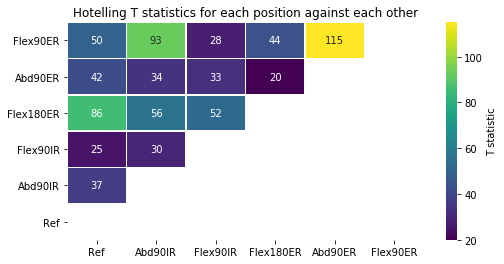

In [14]:
spm_heatmap(H_heatmap, title='Hotelling T statistics for each position against each other', labels=names_positions, save_fig=True, cmap='viridis')

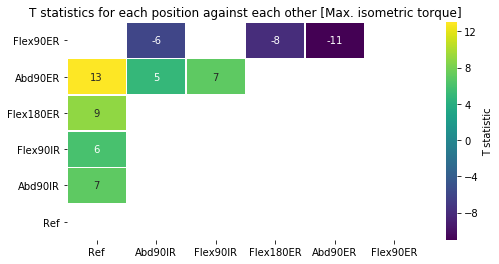

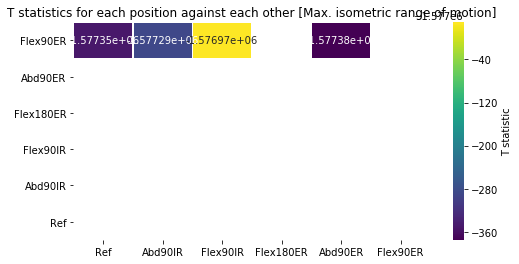

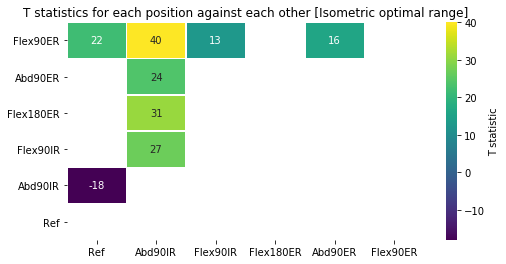

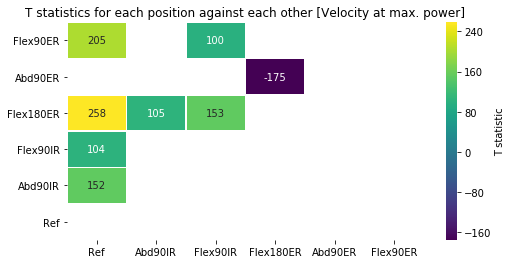

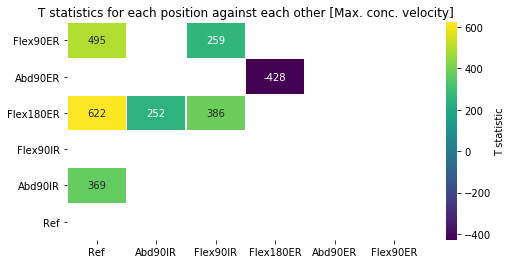

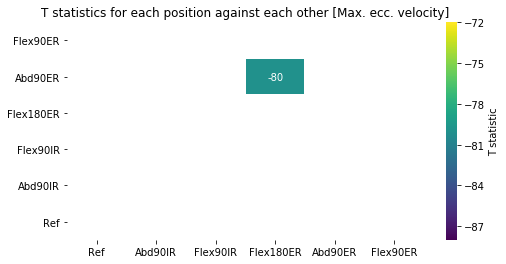

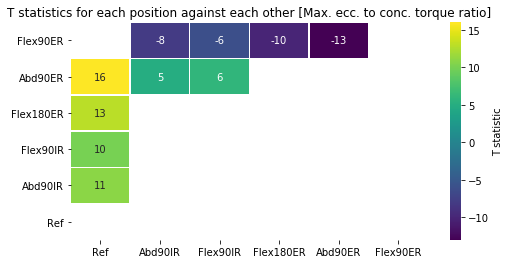

In [15]:
for iparameter in range(nparameter):
    spm_heatmap(T_heatmap[:, :, iparameter], title=f'T statistics for each position against each other [{names_parameters[iparameter]}]', labels=names_positions, save_fig=True)